# Data Mining & Machine Learning - Classification Part 3.1

### Case 1: Classification of Legendary Pokémon with Supervised Learning

83109 Samuel Didovic<br>
86368 Isabel Lober<br>
85915 Pascal Seitz<br>

Lecturer: Prof. Dr. Adrian Moriariu

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, f1_score, precision_recall_curve

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("pokemon_cleaned.csv")
df["type2"].fillna("None", inplace = True)
df["percentage_male"].fillna("None", inplace = True)

In [4]:
df_train = df.drop(columns = ["name", "abilities", "classification"], axis = 1)
df_train = pd.get_dummies(df_train, columns = ["type1", "type2", "percentage_male"], dtype = int, drop_first = False)

The `train_test_split` function is a utility provided by the `sklearn.model_selection` module. It is used to split a dataset into training and testing subsets.

- **test_size**: This parameter specifies the proportion of the dataset to include in the test split. We set it to `0.2`, meaning 20 % of the data will be used for testing, and the remaining 80 % will be used for training.

- **random_state**: This parameter controls the shuffling applied to the data before the split. Setting it to a specific integer value (e.g., `42`) ensures that the split will be reproducible. Every time the code is run with the same `random_state`, the result will be the same.

- **stratify**: This parameter ensures that the training and test sets have the same proportion of samples for each class as the original dataset. It is particularly useful for imbalanced datasets. By passing the target variable `y`, we ensure that the class distribution is maintained in both the training and test sets.

In [5]:
# Define features and target variable
X = df_train.drop(columns = ["is_legendary"], axis = 1).values
y = df_train["is_legendary"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, stratify = y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 640
Test set size: 161


## 1. k-Nearest Neighbors Model

### 1.1 k-Nearest Neighbors Model - a first approach

In [6]:
# Initialize the kNN model
knn = KNeighborsClassifier()

# Train the model
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [7]:
# Actual prediction
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

**Evaluation Metrics**

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. High precision indicates a low false positive rate.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class. High recall indicates a low false negative rate.
- **F1-Score**: The weighted average of precision and recall. It is useful when the class distribution is imbalanced.
- **Cross-Validation F1-Score**: The average F1-Score across different folds of the dataset.
- **AUC-ROC**: A measure of the model's ability to distinguish between classes. Higher AUC indicates better performance.

Training accuracy: 0.9922
Testing accuracy: 0.9689
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       147
           1       0.74      1.00      0.85        14

    accuracy                           0.97       161
   macro avg       0.87      0.98      0.92       161
weighted avg       0.98      0.97      0.97       161

Cross-Validation F1-Score: [0.9        0.86956522 0.91666667 0.95238095 1.        ]
Average Cross-Validation F1-Score: 0.9277
AUC-ROC: 0.9971


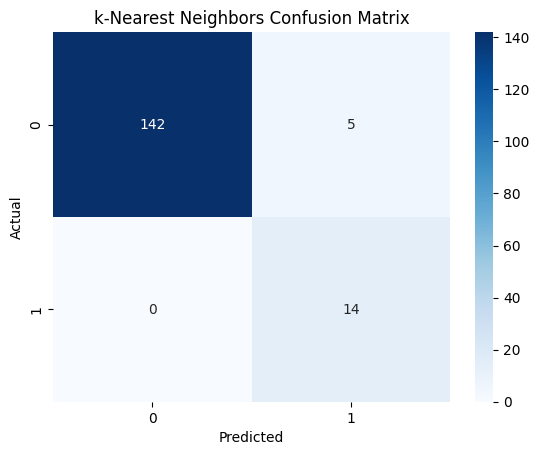

In [8]:
# Evaluation of the model
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)
classification_rep = classification_report(y_test, y_test_pred)

# Cross-Validation scores
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 101)
cv_scores = cross_val_score(knn, X_train, y_train, cv = skf, scoring = "f1")

# AUC_ROC
y_test_prob = knn.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_test_prob)

# Print the metrics
print(f"Training accuracy: {train_score:.4f}")
print(f"Testing accuracy: {test_score:.4f}")
print("Classification Report:\n", classification_rep)
print(f"Cross-Validation F1-Score: {(cv_scores)}")
print(f"Average Cross-Validation F1-Score: {np.mean(cv_scores):.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_knn, annot = True, fmt = "d", cmap = "Blues")
plt.title("k-Nearest Neighbors Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Precision-Recall Curve**

The Precision-Recall curve is a graphical representation of the trade-off between precision and recall for different threshold values of a classification model. It is especially useful when dealing with imbalanced datasets.

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class.

The curve helps in understanding the balance between precision and recall. A high area under the curve represents both high recall and high precision, indicating a model with good performance.

**ROC Curve and AUC-ROC**

The ROC (Receiver Operating Characteristic) curve is a graphical representation of the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots the True Positive Rate (Recall) against the False Positive Rate.

- **True Positive Rate (Recall)**: The ratio of correctly predicted positive observations to all actual positives.
- **False Positive Rate**: The ratio of incorrectly predicted positive observations to all actual negatives.

The AUC-ROC (Area Under the ROC Curve) provides a single measure of overall model performance. A higher AUC value indicates a better-performing model.

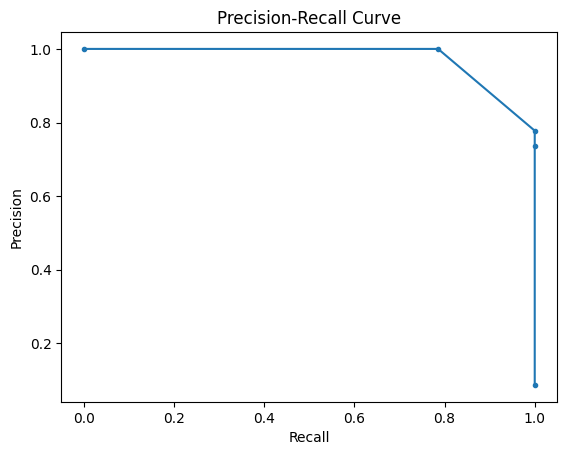

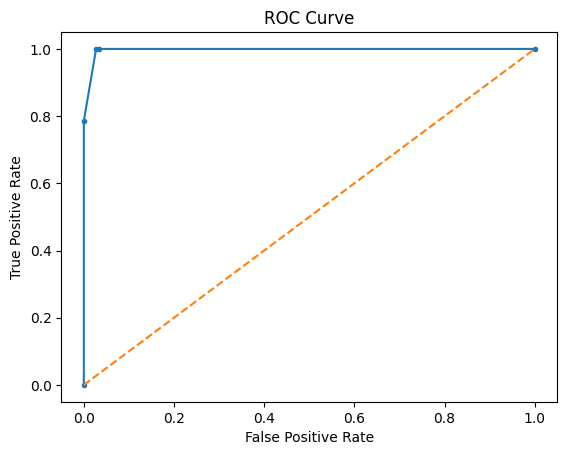

In [9]:
# Precision-Recall Curve
y_scores = knn.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC-Curve und AUC-value
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.show()

### 1.2 Improved k-Nearest Neighbors Model with Scaling and addressing Class Imbalance

In our initial model, we trained a kNN model without scaling the data and without addressing class imbalance. This was intended to demonstrate the importance of these steps:
1. **Sensitivity to Scaling**: kNN is a distance-based algorithm, meaning that features with larger scales can disproportionately influence the distance calculations.
2. **Class Imbalance**: Ignoring class imbalance can lead to biased predictions, favoring the majority class.

**StandardScaler vs. MinMaxScaler**

- **StandardScaler**: Standardizes features by removing the mean and scaling to unit variance. The resulting distribution has a mean of 0 and a standard deviation of 1. This scaling is less sensitive to outliers.
- **MinMaxScaler**: Transforms features by scaling each feature to a given range, typically [0, 1]. This scaling can be more affected by outliers.

We use `StandardScaler` because it centers the data and scales it to have unit variance, which is suitable for algorithms like kNN that assume normally distributed data. Additionally, it is less sensitive to outliers compared to `MinMaxScaler`.

In [10]:
# Scale the data on the same scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # One could split this function into two separate ones.
X_test_scaled = scaler.transform(X_test)

In the improved model, we:
1. **Scale the Data**: Using `StandardScaler` to transform features to a common scale.
2. **Address Class Imbalance**: Using the `weights='distance'` parameter in `KNeighborsClassifier` to weight points by the inverse of their distance. This helps in giving closer neighbors more influence, which can mitigate the effects of class imbalance.

In [11]:
# Initialize the kNN model with "distance" weights to address class imbalance
knn = KNeighborsClassifier(weights = "distance")

# Train the model
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(weights='distance')

**Evaluation Metrics**

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. High precision indicates a low false positive rate.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class. High recall indicates a low false negative rate.
- **F1-Score**: The weighted average of precision and recall. It is useful when the class distribution is imbalanced.
- **Cross-Validation F1-Score**: The average F1-Score across different folds of the dataset.
- **AUC-ROC**: A measure of the model's ability to distinguish between classes. Higher AUC indicates better performance.

In [12]:
# Actual prediction
y_train_pred = knn.predict(X_train_scaled)
y_test_pred = knn.predict(X_test_scaled)

Training accuracy: 1.0000
Testing accuracy: 0.9565
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       147
           1       0.89      0.57      0.70        14

    accuracy                           0.96       161
   macro avg       0.92      0.78      0.84       161
weighted avg       0.95      0.96      0.95       161

Cross-Validation F1-Score: [0.81818182 0.8        0.9        0.84210526 0.8       ]
Average Cross-Validation F1-Score: 0.8321
AUC-ROC: 0.9922


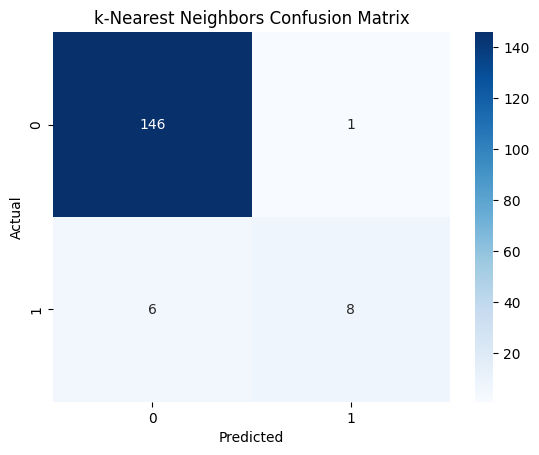

In [13]:
# Evaluation of the model
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)
classification_rep = classification_report(y_test, y_test_pred)

# Cross-Validation scores
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 101)
cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv = skf, scoring = "f1")

# AUC_ROC
y_test_prob = knn.predict_proba(X_test_scaled)[:, 1]
auc_roc = roc_auc_score(y_test, y_test_prob)

# Print the metrics
print(f"Training accuracy: {train_score:.4f}")
print(f"Testing accuracy: {test_score:.4f}")
print("Classification Report:\n", classification_rep)
print(f"Cross-Validation F1-Score: {(cv_scores)}")
print(f"Average Cross-Validation F1-Score: {np.mean(cv_scores):.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_knn, annot = True, fmt = "d", cmap = "Blues")
plt.title("k-Nearest Neighbors Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Precision-Recall Curve**

The Precision-Recall curve is a graphical representation of the trade-off between precision and recall for different threshold values of a classification model. It is especially useful when dealing with imbalanced datasets.

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class.

The curve helps in understanding the balance between precision and recall. A high area under the curve represents both high recall and high precision, indicating a model with good performance.

**ROC Curve and AUC-ROC**

The ROC (Receiver Operating Characteristic) curve is a graphical representation of the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots the True Positive Rate (Recall) against the False Positive Rate.

- **True Positive Rate (Recall)**: The ratio of correctly predicted positive observations to all actual positives.
- **False Positive Rate**: The ratio of incorrectly predicted positive observations to all actual negatives.

The AUC-ROC (Area Under the ROC Curve) provides a single measure of overall model performance. A higher AUC value indicates a better-performing model.

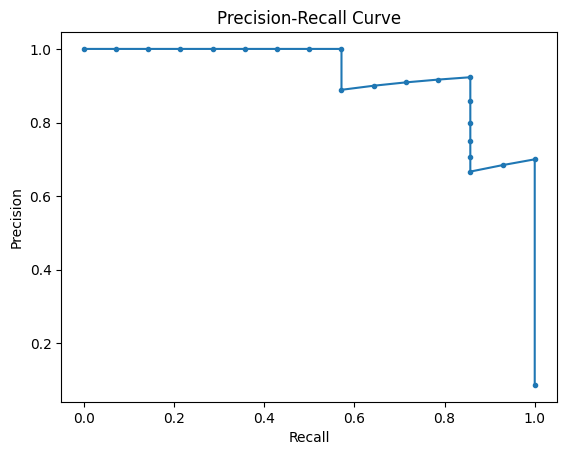

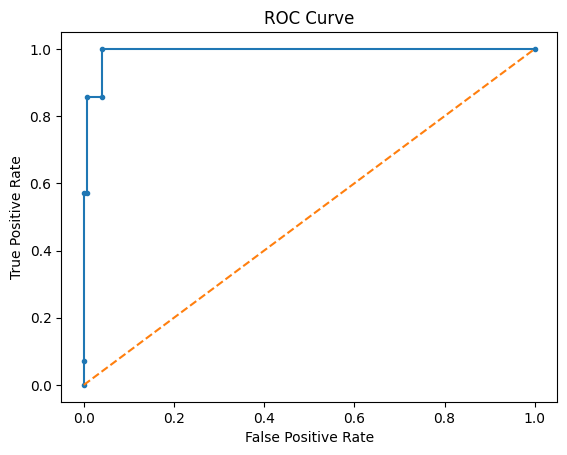

In [14]:
# Precision-Recall Curve
y_scores = knn.predict_proba(X_test_scaled)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC-Curve und AUC-value
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.show()

### 1.3 Hyperparameter Optimization using GridSearchCV

In our initial models, we saw that kNN was sensitive to scaling and class imbalance. We addressed these issues and improved the model by scaling the data using `StandardScaler` and handling class imbalance using the `weights='distance'` parameter.

Despite improvements, our model can still be fine-tuned. Hyperparameter optimization using `GridSearchCV` helps in finding the best combination of hyperparameters for our model, leading to potentially better performance.

`GridSearchCV` performs an exhaustive search over a specified parameter grid.

1. **Parameter Grid**: Define a range of hyperparameters to search.
    - `n_neighbors`: Number of neighbors to use.
    - `weights`: Weight function used in prediction ('uniform' or 'distance').
    - `metric`: Distance metric to use ('euclidean' or 'manhattan').

2. **Cross-Validation**: Use 5-fold cross-validation to evaluate the model.

3. **Scoring**: Use `f1` to optimize for a balance between precision and recall, especially in imbalanced datasets.

In [15]:
# Define parameters for Grid Search
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

# Initialize the model
knn_grid = KNeighborsClassifier()

# Grid Search with Cross-Validation
grid_search_knn = GridSearchCV(estimator = knn_grid,
                               param_grid = param_grid,
                               cv = 5,
                               n_jobs = -1,
                               verbose = 2,
                               scoring = "f1")

grid_search_knn.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='f1', verbose=2)

In [16]:
# Get best parameters
best_params = grid_search_knn.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}


In [17]:
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=3)

In [18]:
# Actual prediction
y_train_pred = best_knn.predict(X_train_scaled)
y_test_pred = best_knn.predict(X_test_scaled)

Training accuracy: 0.9922
Testing accuracy: 0.9876
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       0.93      0.93      0.93        14

    accuracy                           0.99       161
   macro avg       0.96      0.96      0.96       161
weighted avg       0.99      0.99      0.99       161

Cross-Validation F1-Score: [0.91666667 0.90909091 1.         0.95238095 0.90909091]
Average Cross-Validation F1-Score: 0.9374
AUC-ROC: 0.9978


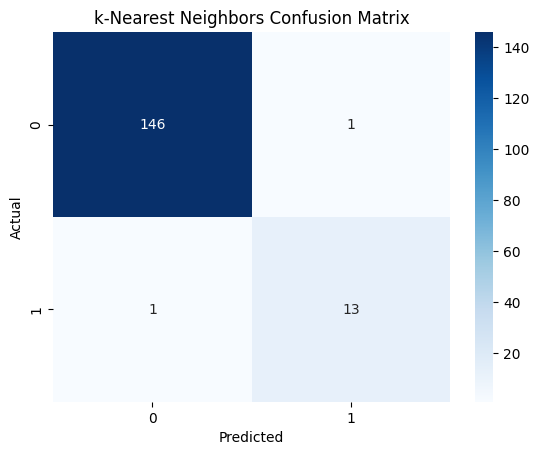

In [19]:
# Evaluation of the model
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)
classification_rep = classification_report(y_test, y_test_pred)

# Cross-Validation scores
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 101)
cv_scores = cross_val_score(best_knn, X_train_scaled, y_train, cv = skf, scoring = "f1")

# AUC_ROC
y_test_prob = best_knn.predict_proba(X_test_scaled)[:, 1]
auc_roc = roc_auc_score(y_test, y_test_prob)

# Print the metrics
print(f"Training accuracy: {train_score:.4f}")
print(f"Testing accuracy: {test_score:.4f}")
print("Classification Report:\n", classification_rep)
print(f"Cross-Validation F1-Score: {(cv_scores)}")
print(f"Average Cross-Validation F1-Score: {np.mean(cv_scores):.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_knn, annot = True, fmt = "d", cmap = "Blues")
plt.title("k-Nearest Neighbors Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Precision-Recall Curve**

The Precision-Recall curve is a graphical representation of the trade-off between precision and recall for different threshold values of a classification model. It is especially useful when dealing with imbalanced datasets.

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class.

The curve helps in understanding the balance between precision and recall. A high area under the curve represents both high recall and high precision, indicating a model with good performance.

**ROC Curve and AUC-ROC**

The ROC (Receiver Operating Characteristic) curve is a graphical representation of the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots the True Positive Rate (Recall) against the False Positive Rate.

- **True Positive Rate (Recall)**: The ratio of correctly predicted positive observations to all actual positives.
- **False Positive Rate**: The ratio of incorrectly predicted positive observations to all actual negatives.

The AUC-ROC (Area Under the ROC Curve) provides a single measure of overall model performance. A higher AUC value indicates a better-performing model.

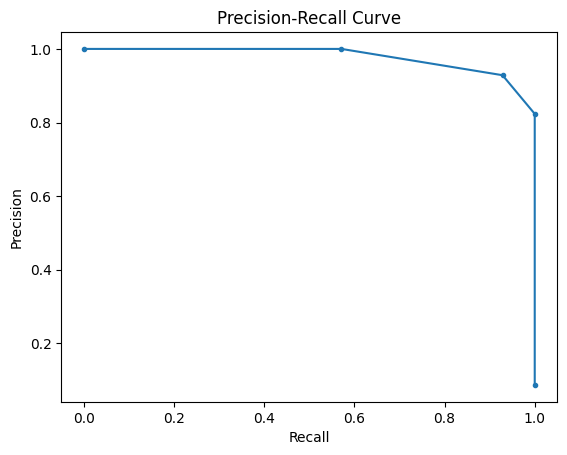

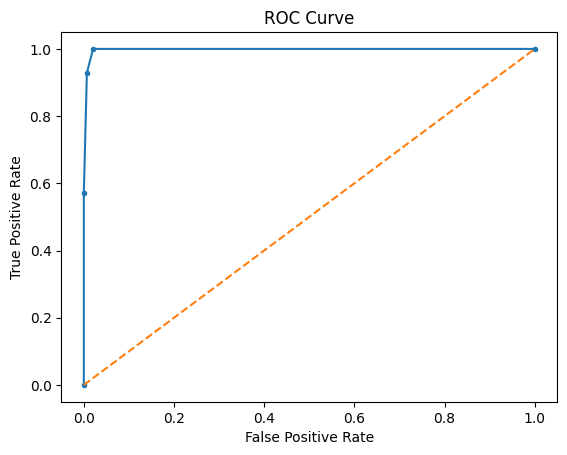

In [20]:
# Precision-Recall Curve
y_scores = best_knn.predict_proba(X_test_scaled)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC-Curve und AUC-value
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.show()

### 1.4 Conclusion

- The hyperparameter optimization process using `GridSearchCV` significantly enhanced the kNN model's performance. By carefully tuning the parameters and addressing scaling and class imbalance, we achieved a model that performs exceptionally well on both training and testing data. The model demonstrates strong generalization capabilities and robust performance.
- In a real-world setting, continuously monitoring the model's performance on new data and updating the model as necessary would be critical to maintaining its reliability.